<h1><center>Twitter US Airline Sentiment Analysis</center></h1>
<h4><i><center>Varun Kulkarni (kulkarnivarun@outlook.com) </center></i></h4>

## Objective
Classify Tweet Sentiment

## Context
A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service"). 


## Data Description
The project is from a dataset from Kaggle.
Link to the Kaggle project site: https://www.kaggle.com/crowdflower/twitter-airline-sentiment
The dataset has to be downloaded from the above Kaggle website.

## Tasks
1. [Reading Dataset and Understanding Columns](#1)
2. [Data Preprocessing](#2)
3. [Sentiment Classification Using CountVectorizer](#3)
4. [Sentiment Classification Using TF-IDF Vectorizer](#4)
5. [Summary](#5)   

In [1]:
# Import relevant libraries
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import numpy as np   
import seaborn as sns
import pandas as pd  
from bs4 import BeautifulSoup
import unicodedata          
import re
import spacy
import nltk                    
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer

# sklearn imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Imports from TF
import tensorflow as tf
from tensorflow.keras import optimizers, losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Activation
from tensorflow.keras.metrics import Recall, Precision

%matplotlib inline
warnings.filterwarnings('ignore')
SEED=42 # 
NUM_FOLDS=10
sns.set(color_codes=True)

## Reading Dataset and Understanding Columns<a class="anchor" id='1'></a>

In [2]:
# Load the dataset
data_df = pd.read_csv('Tweets.csv')
data_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
# Shape of the dataset
print("There are {0} records and {1} variables.".format(data_df.shape[0], data_df.shape[1]))
    
# Check for duplicated values
print("Number of duplicated records: ", data_df.duplicated().sum())

There are 14640 records and 15 variables.
Number of duplicated records:  36


In [4]:
# Examine type of the data
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [5]:
# Drop all other columns except “text” and “airline_sentiment”.
cols_to_retain = set(['text', 'airline_sentiment'])
sentiment_df = data_df.drop(columns=[col for col in data_df.columns.to_list() 
                                     if col not in cols_to_retain])

# Print the shape of the filtered data
print("Shape of filtered data: ", sentiment_df.shape)

# Print first 5 rows
sentiment_df.head(5)

Shape of filtered data:  (14640, 2)


,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [6]:
sentiment_df.groupby('airline_sentiment')['airline_sentiment'].count()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

#### Observations:
- Given dataset has considerable number of data-columns, which could be used for reasoning post sentiment analysis or classification.
- The two main columns of interest are: 'text' - the text of the tweet itself and 'airline_sentiment' - the corresponding sentiment associated with it.
- There are three sentiments noted in this dataset, namely negative, neutral and positive.
- Number of negative sentiments are significantly higher as compared to neutral and positive sentiments.
- The dataset is skewed with considerably higher number of negative sentiments and this can affect the classification accuracy for neutral and positive reviews.

## Data Preprocessing<a class="anchor" id='2'></a>

In [7]:
# Check for duplicates
print("Dropping {0} duplicates.".format(sentiment_df.duplicated().sum()))
sentiment_df.drop_duplicates(inplace=True)
print("Shape of updated data: ", sentiment_df.shape)

Dropping 188 duplicates.
Shape of updated data:  (14452, 2)


In [8]:
# Define set of stop words
stop_words = set(stopwords.words("english"))

# Load spacy for lemmatization
sp = spacy.load('en_core_web_sm', parse=True, tag=True, entity=True)

def clean_review(raw_review):    
    '''Method to clean raw review - 
    - HTML tag removal,
    - Numerics removal
    - Removal of special chars and punctuations
    - Tokenization,
    - Conversion to lower case
    - Lemmatize or stemming
    - Join clean words
    
    raw_review: Raw text of the review as string
    '''
    # Remove HTML tags
    review_text = BeautifulSoup(raw_review).get_text()    
    
    # Remove accented characters
    review_text = unicodedata.normalize('NFKD', review_text).encode('ascii', 
                                            'ignore').decode('utf-8', 'ignore')
    
    # Remove URLs
    review_text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', ' ', 
                         review_text, flags=re.MULTILINE)
    
    # Remove non-letters - numbers, special characters and punctuations.
    review_text = re.sub("[^a-zA-Z]", " ", review_text) 
    
    # Tokenize
    words = [word.lower() for word in ToktokTokenizer().tokenize(review_text)]
    
    # Remove stop words
    meaningful_words = [word for word in words if not word in stop_words]
    meaningful_words = " ".join(meaningful_words)
    
    # Lemmatize the text
    sentence = sp(meaningful_words)
    lemmatized_words = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text 
                                     for word in sentence])
        
    # return lemmatized text
    return lemmatized_words


# Let's print first five sample reviews and the processed results
for idx in range(0, 6):
    original_review = sentiment_df['text'][idx]
    cleaned_review = clean_review(original_review)
    print("Original Review:", original_review)
    print("Cleaned review: ", cleaned_review)
    print()

print()
print('....')
print('....')
print()

# Let's print some more
for idx in range(100, 106):
    original_review = sentiment_df['text'][idx]
    cleaned_review = clean_review(original_review)
    print("Original Review:", original_review)
    print("Cleaned review: ", cleaned_review)
    print()

Original Review: @VirginAmerica What @dhepburn said.
Cleaned review:  virginamerica dhepburn say

Original Review: @VirginAmerica plus you've added commercials to the experience... tacky.
Cleaned review:  virginamerica plus add commercial experience tacky

Original Review: @VirginAmerica I didn't today... Must mean I need to take another trip!
Cleaned review:  virginamerica today must mean need take another trip

Original Review: @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
Cleaned review:  virginamerica really aggressive blast obnoxious entertainment guest face little recourse

Original Review: @VirginAmerica and it's a really big bad thing about it
Cleaned review:  virginamerica really big bad thing

Original Review: @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
Cleaned review:  virginamerica seriously would pay fl

In [9]:
# Update the reviews in the sentiment data frame
original_reviews = sentiment_df['text'].to_list()
cleaned_reviews = [clean_review(review) for review in original_reviews]
sentiment_df['clean_text'] = cleaned_reviews

# Drop original text data and update sentiments to numeric values
data_df = sentiment_df.drop(columns=['text'])
data_df = pd.get_dummies(data_df, columns=['airline_sentiment'], prefix='', prefix_sep='')

# Display data
data_df

,clean_text,negative,neutral,positive
0,virginamerica dhepburn say,0,1,0
1,virginamerica plus add commercial experience t...,0,0,1
2,virginamerica today must mean need take anothe...,0,1,0
3,virginamerica really aggressive blast obnoxiou...,1,0,0
4,virginamerica really big bad thing,1,0,0
...,...,...,...,...
14635,americanair thank get different flight chicago,0,0,1
14636,americanair leaving minute late flight warning...,1,0,0
14637,americanair please bring american airlines bla...,0,1,0
14638,americanair money change flight answer phone s...,1,0,0


### Utility methods for creating neural net based classification model and assessing its performance


In [10]:
def get_classifier(input_shape, lr=1e-3):
    '''Method to build a simple classifier based on TF sequential model
    input_shape: shape of the input layer
    lr: learning rate
    '''   
    # Create sequential model
    model = Sequential() 
    model.add(InputLayer(input_shape=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())    
    model.add(Dense(3, activation='softmax'))

    # Create optimizer instance 
    opt = optimizers.Adam(lr=lr)

    # Configure the model with categorical cross entropy loss, the optimizer, and accuracy as the metrics
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def plot_train_hist_loss(train_hist):
    '''Method to plot train loss and validation loss. Mainly to check for overfitting.
    train_hist: training history
    '''
    train_hist_df = pd.DataFrame(train_hist.history)
    plt.figure(figsize=(10, 7))
    plt.plot(train_hist_df['loss'])
    plt.plot(train_hist_df['val_loss'])
    plt.legend(("train loss" , "validation loss"), loc=0)
    
def get_model_perf(model, x_train, y_train, x_test, y_test, batch_size=5):
    '''Method to get performance of the model. Assumes model is fitted
    '''
    y_pred = model.predict(x_test)
    
    perf_dict = {}
    # Get train accuracy
    results = model.evaluate(x_train, y_train, batch_size=batch_size, verbose=False)
    perf_dict['Train accuracy'] = round(results[1] * 100,3)
    
    # Get test accuracy
    results = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=False)
    perf_dict['Test accuracy'] = round(results[1] * 100,3)

    # Let's look at the precision and recall for the model.
    recall, precision = Recall(), Precision()
    recall.update_state(y_test, y_pred)
    precision.update_state(y_test, y_pred)
    perf_dict['Recall Score'] = round(recall.result().numpy(), 3)
    perf_dict['Precision Score'] = round(precision.result().numpy(), 3)  
    
    return perf_dict

def plot_confusion_matrix(model, x_test, y_test, labels, title):
    '''Method to plot the confusion matrix. Assumes the model is fitted'''
    y_pred = model.predict(x_test)
    
    # Get model predictions
    y_test_labels = []
    y_pred_labels = []
    for t, p in zip(y_test, y_pred):
        y_test_labels.append(np.argmax(t))
        y_pred_labels.append(np.argmax(p))

    # Compute the confusion matrix
    cm = tf.math.confusion_matrix(y_test_labels, y_pred_labels)
    cm = np.asarray(cm)

    # Plot the matrix
    plt.figure(figsize=(12,7))
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    sns.heatmap(cm_df, annot=True, linewidths=0.3, annot_kws={"fontsize":15}, fmt='g')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    plt.show()

## Sentiment Classification Using Count Vectorizer <a class="anchor" id='3'></a>

In [11]:
# Vectorize cleaned reviews with CountVectorizer
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, 
                            stop_words = None, max_features=10000) 

train_data_features = vectorizer.fit_transform(cleaned_reviews)
train_data_features = train_data_features.toarray()
print('There are {0} reviews with {1} features'.format(train_data_features.shape[0], train_data_features.shape[1]))

There are 14452 reviews with 10000 features


In [12]:
# Get the vocabulary
vocab = vectorizer.get_feature_names()

# Sum up the counts of each word
freq = np.sum(train_data_features, axis=0)

vocab_freq = [(x,y) for x, y in zip(vocab, freq)]
vacab_freq_sorted = sorted(vocab_freq, key=lambda x: x[1], reverse=True)

# Display top 10 vocab words by their frequency of occurence
print(*vacab_freq_sorted[0:10], sep='\n')

('flight', 4631)
('united', 4113)
('americanair', 2818)
('southwestair', 2451)
('jetblue', 2385)
('usairway', 2378)
('get', 2097)
('thank', 1487)
('hour', 1148)
('cancel', 1045)


In [13]:
# Prepare data for training
X = train_data_features
Y = data_df.iloc[:,1:]
labels = data_df.columns.to_list()[1:]
Y = np.array(Y)

# Normalize/scale the data
scaler = RobustScaler()
X = scaler.fit_transform(X)

# Train test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=SEED, stratify=Y)

# Print distributions
print('Sentiment labels: ', labels)
print()
print('Train data:')
print('X Train Shape:', x_train.shape)
print('Y Train Shape:', y_train.shape)
print()
print('Test Data:')
print('X Test Shape:', x_test.shape)
print('Y Test Shape:', y_test.shape)

Sentiment labels:  ['negative', 'neutral', 'positive']

Train data:
X Train Shape: (11561, 10000)
Y Train Shape: (11561, 3)

Test Data:
X Test Shape: (2891, 10000)
Y Test Shape: (2891, 3)


### Classification with Random Forrest Classifier and Count Vectorizer

In [14]:
# Initialize a Random Forest classifier with 100 trees
classifier = RandomForestClassifier(n_jobs=-1, n_estimators=100, verbose=0) 
print('Classifier: ', classifier)

# Random forest performance through cross vaidation
result = np.mean(cross_val_score(classifier, X, Y, cv=10))
print('Random Forrest Classification Accuracy with CountVectorizer: ', round(result*100.0,3))

Classifier:  RandomForestClassifier(n_jobs=-1)
Random Forrest Classification Accuracy with CountVectorizer:  68.537


### Classification with Neural Network and Count Vectorizer

In [15]:
# Get classifier instance and print model summary
classifier = get_classifier(input_shape=(10000,), lr=1e-5)
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 5

In [16]:
# Train the model.
train_hist = None

# Hyperparameters for training
epochs = 50
batch_size = 4
val_split = 0.2
verbose = True

# Note: The model is being trained on physical GPU instance. If no physical GPU is present then,
# comment out below line to train the model on CPU.
with tf.device('/device:GPU:0'):    
    train_hist = classifier.fit(x_train, y_train, epochs=epochs, validation_split=val_split, 
                                batch_size=batch_size, verbose=verbose)

Train on 9248 samples, validate on 2313 samples
Epoch 1/50
9248/9248 [==============================] - 63s 7ms/sample - loss: 1.3661 - accuracy: 0.3715 - val_loss: 1.5986 - val_accuracy: 0.3610
Epoch 2/50
9248/9248 [==============================] - 5s 525us/sample - loss: 1.2773 - accuracy: 0.3915 - val_loss: 1.4718 - val_accuracy: 0.3960
Epoch 3/50
9248/9248 [==============================] - 5s 525us/sample - loss: 1.1914 - accuracy: 0.4343 - val_loss: 1.3974 - val_accuracy: 0.4168
Epoch 4/50
9248/9248 [==============================] - 5s 529us/sample - loss: 1.1183 - accuracy: 0.4650 - val_loss: 1.3315 - val_accuracy: 0.4401
Epoch 5/50
9248/9248 [==============================] - 5s 521us/sample - loss: 1.0553 - accuracy: 0.5032 - val_loss: 1.2646 - val_accuracy: 0.4643
Epoch 6/50
9248/9248 [==============================] - 5s 528us/sample - loss: 1.0158 - accuracy: 0.5221 - val_loss: 1.2067 - val_accuracy: 0.4829
Epoch 7/50
9248/9248 [==============================] - 5s 526us/

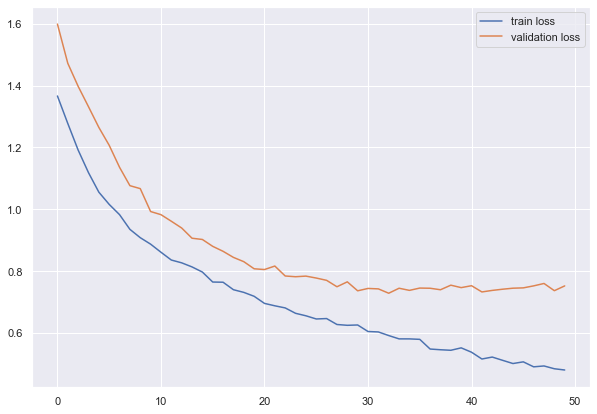

In [17]:
# Let's plot the losses from training history to check if there was overfitting. 
# Continuous decrease in train loss but increase in validation loss would indicate overfitting.
plot_train_hist_loss(train_hist)

In [18]:
# Let's look at the classifier performance
perf = get_model_perf(classifier, x_train, y_train, x_test, y_test, batch_size=batch_size)
pd.DataFrame(perf, index=['Performance with Neural Network and CountVectorizer']).T

,Performance with Neural Network and CountVectorizer
Train accuracy,87.371
Test accuracy,71.152
Recall Score,0.688
Precision Score,0.731


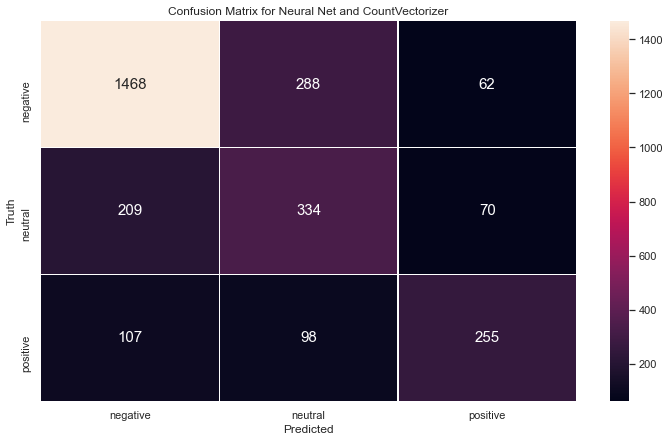

In [19]:
# Let's look at the confusion matrix
plot_confusion_matrix(classifier, x_test, y_test, labels, title='Confusion Matrix for Neural Net and CountVectorizer')

#### Observations:
- Count Vectorizer helped in vectorizing the preprocessed text and convert it to bag of words.
- We experimented with two classifier models - Random Forrest Classifier and Neural Net based model.
- Random Forrest Classifier performed fairly well on the vectorized data of bag of words with reasonable accuracy.
- The Neural Net based model performed better than Random Forrest Classifier and demonstrated better classification performance.
- Since the number of negative reviews are highest, the true positives for negative reviews are better than those for neutral and positive reviews.
- True positives for neutral reviews are second best and are better than those for positive reviews.
- False positives and false negatives for neutral and positive sentiments are higher than those for neutral reviews.

## Classifying Sentiments using TF-IDF Vectorizer <a class="anchor" id='4'></a>

In [20]:
# Vectorize cleaned reviews with IF-IDF Vectorizer
vectorizer = TfidfVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, 
                            stop_words = None, max_features=10000, sublinear_tf=True)
train_data_features = vectorizer.fit_transform(cleaned_reviews)
train_data_features = train_data_features.toarray()
print('There are {0} reviews with {1} features'.format(train_data_features.shape[0], train_data_features.shape[1]))

There are 14452 reviews with 10000 features


In [21]:
# Prepare data for training
X = train_data_features
Y = data_df.iloc[:,1:]
labels = data_df.columns.to_list()[1:]
Y = np.array(Y)

# Normalize the data
scaler = RobustScaler()
X = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=SEED, stratify=Y)

# Print distributions
print('Sentiment labels: ', labels)
print()
print('Train data:')
print('X Train Shape:', x_train.shape)
print('Y Train Shape:', y_train.shape)
print()
print('Test Data:')
print('X Test Shape:', x_test.shape)
print('Y Test Shape:', y_test.shape)

Sentiment labels:  ['negative', 'neutral', 'positive']

Train data:
X Train Shape: (11561, 10000)
Y Train Shape: (11561, 3)

Test Data:
X Test Shape: (2891, 10000)
Y Test Shape: (2891, 3)


### Classification with Random Forrest Classifier and TF-IDF Vectorizer

In [22]:
# Initialize a Random Forest classifier with 100 trees
classifier = RandomForestClassifier(n_jobs=-1, n_estimators=100, verbose=0) 
print('Classifier: ', classifier)

# Random forest performance through cross vaidation
result = np.mean(cross_val_score(classifier, X, Y, cv=10))
print('Random Forrest Classification Accuracy with TF-IDF Vectorizer: ', round(result*100.0,3))

Classifier:  RandomForestClassifier(n_jobs=-1)
Random Forrest Classification Accuracy with TF-IDF Vectorizer:  69.368


### Classification with Neural Net based Classifier and Count Vectorizer

In [23]:
# Get classifier instance and print summary
classifier = get_classifier(input_shape=(10000,), lr=1e-5)
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                640064    
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_4 (Batch (None, 32)                128       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_5 (Batch (None, 16)                64        
_________________________________________________________________
dense_7 (Dense)              (None, 3)                

In [24]:
# Train the model.
train_hist = None

# Hyperparameters for training
epochs = 50
batch_size = 4
val_split = 0.2
verbose = True

# Note: The model is being trained on physical GPU instance. If no physical GPU is present then,
# comment out below line to train the model on CPU.
with tf.device('/device:GPU:0'):    
    train_hist = classifier.fit(x_train, y_train, epochs=epochs, validation_split=val_split, batch_size=batch_size, 
                                verbose=verbose)

Train on 9248 samples, validate on 2313 samples
Epoch 1/50
9248/9248 [==============================] - 6s 612us/sample - loss: 1.4462 - accuracy: 0.3187 - val_loss: 1.4477 - val_accuracy: 0.3878
Epoch 2/50
9248/9248 [==============================] - 5s 529us/sample - loss: 1.3005 - accuracy: 0.3625 - val_loss: 1.3186 - val_accuracy: 0.4042
Epoch 3/50
9248/9248 [==============================] - 5s 528us/sample - loss: 1.2149 - accuracy: 0.3980 - val_loss: 1.2273 - val_accuracy: 0.4518
Epoch 4/50
9248/9248 [==============================] - 5s 526us/sample - loss: 1.1256 - accuracy: 0.4396 - val_loss: 1.1383 - val_accuracy: 0.4760
Epoch 5/50
9248/9248 [==============================] - 5s 524us/sample - loss: 1.0683 - accuracy: 0.4694 - val_loss: 1.0979 - val_accuracy: 0.5089
Epoch 6/50
9248/9248 [==============================] - 5s 522us/sample - loss: 1.0274 - accuracy: 0.5008 - val_loss: 1.0339 - val_accuracy: 0.5201
Epoch 7/50
9248/9248 [==============================] - 5s 519us

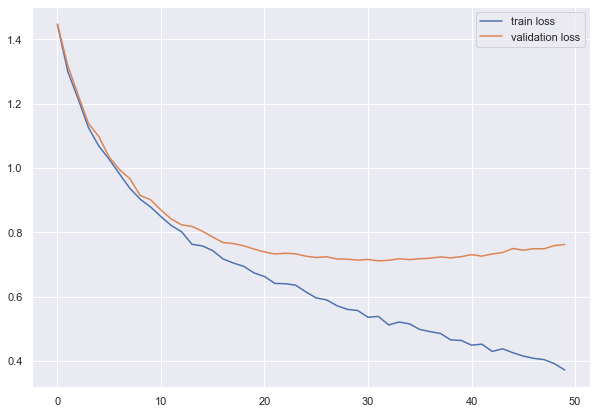

In [25]:
# Let's plot the losses from training history to check if there was overfitting. 
# Continuous decrease in train loss but increase in validation loss would indicate overfitting.
plot_train_hist_loss(train_hist)

In [26]:
# Let's look at the classifier performance using TF-IDF vectorizer
perf = get_model_perf(classifier, x_train, y_train, x_test, y_test, batch_size=batch_size)
pd.DataFrame(perf, index=['Performance with Neural Network and TF-IDF Vectorizer']).T

,Performance with Neural Network and TF-IDF Vectorizer
Train accuracy,90.909
Test accuracy,70.633
Recall Score,0.681
Precision Score,0.721


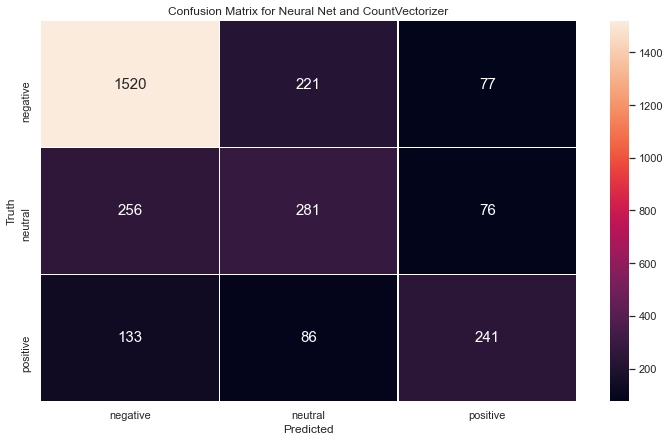

In [27]:
# Let's look at the confusion matrix
plot_confusion_matrix(classifier, x_test, y_test, labels, title='Confusion Matrix for Neural Net and CountVectorizer')

#### Observations:
- TF-IDF Vectorization considers the relative importance of words across the corpus. 
- Random Forrest Classifier performed better with TF-IDF based vectorization.
- Neural Net based Classifier with TF-IDF vectorization, performed very close to that of count vectorization. May be further hyper parameter tuning would yield better results.

## Summary and Concluding Remarks <a class="anchor" id='5'></a>

- The raw-text of the tweets was preprocessed to remove HTML tags, numbers, special characters and punctuations. The text was then tokenized, converted to lower case and lemmatized.
- Preprocessing of the raw text of tweets was extremely important as it brought semantic consistency to the corpus and reduced lot of unwanted words that would have not contributed to the sentiment. 
- The Count Vectorizer helped in creating bag of words but lost the order of the words and hence their relative importance. 
- TF-IDF Vectorizer added importance to the words based on how they appeared not just in their own document, but also in the entire corpus. 
- Random Forrest classifier performed slightly better with TF-IDF vectorization as compared to the count vectorization.
- The Neural Net based model performed better than the Random Forrest Classifier. Unlike Random Forrest Classifier, this model performed slightly better with count vectorization may be because it was able to capture the token relationships better with count vectorization. 

FURTHER IMPROVEMENTS:
- Semantic tokenization can further help to get the better tokenization. Such as, 'aaadvantage' could have broken down into 'aa' and 'advantage.
- Use of Bi or Tri gram based models and tokenization can help with capturing significance of sequence of words in a tweet. This can further improve the classification performance.
- Some advanced neural net architectures, including RNN, LSTM, GRU and attention techniques, can help capture the significance of variable length word sequences and result in the much better classification performance.